# West Nile Virus Prediction Model and Cost Analysis (Part 2/3)

# 1 Initialization

In [1]:
# Disable Future Warning
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Import Vanilla Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Random Sampling Libraries
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

# Pandas Settings
pd.set_option('max_columns', 999)
pd.set_option('max_rows', 10)

In [4]:
# Machine Learning Libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, recall_score
from sklearn.metrics import accuracy_score, classification_report,roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from xgboost import XGBClassifier

# Geospatial Libraries
import folium

In [5]:
# Load in the datasets
train = pd.read_csv('./assets/train_final.csv', parse_dates=['Date'])
test = pd.read_csv('./assets/test_final.csv', parse_dates=['Date'])
spray = pd.read_csv('./assets/spray.csv', parse_dates=['Date'])
weather = pd.read_csv('./assets/cleaned_weather.csv', parse_dates=['Date'])

# 2 Exploratory Analysis

## 2.1 General EDA

In [6]:
print("Number of Rows in Train-set:", train.shape[0])
print("Number of Rows in Test-set:", test.shape[0])

Number of Rows in Train-set: 9693
Number of Rows in Test-set: 116293


In [7]:
round(train['WnvPresent'].value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

Here we can see that there are serious class imbalance in the dataset where the majority class 0 has over 95% as compared to class 1 of 5%. We would have to express this circumstances with the help of either undersampling or oversampling in the modelling attempt later on.

However for now, we will look more into the distribution and relationship of different features in the dataset, which would help with the feature selection and feature engineering.

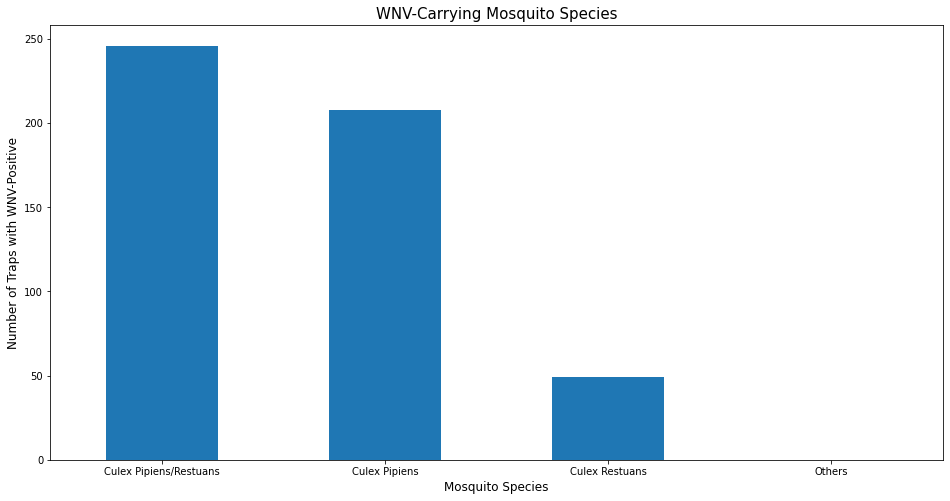

In [8]:
### Comparison of Mosquito Species as WNV Carrier ###
plt.figure(figsize=(16,8))
train.groupby('Species').sum()['WnvPresent'].sort_values(ascending=False).plot(kind='bar')
plt.xticks(range(4), ['Culex Pipiens/Restuans', 'Culex Pipiens', 'Culex Restuans', 'Others'], rotation=0)
plt.xlabel('Mosquito Species', fontsize=12)
plt.ylabel('Number of Traps with WNV-Positive', fontsize=12)
plt.title('WNV-Carrying Mosquito Species', fontsize=15)
plt.show()

From the bar-chart comparison above, it seems that only the Culex Pipiens and Culex Restuans mosquito species carry the West Nile Virus while all other species do not. This is the reason why all other species in the dataset has been grouped together in Part 1 of the project. With only 4 groups of species in our dataset, it reduces the dimensionality of our data after one-hot encoding.

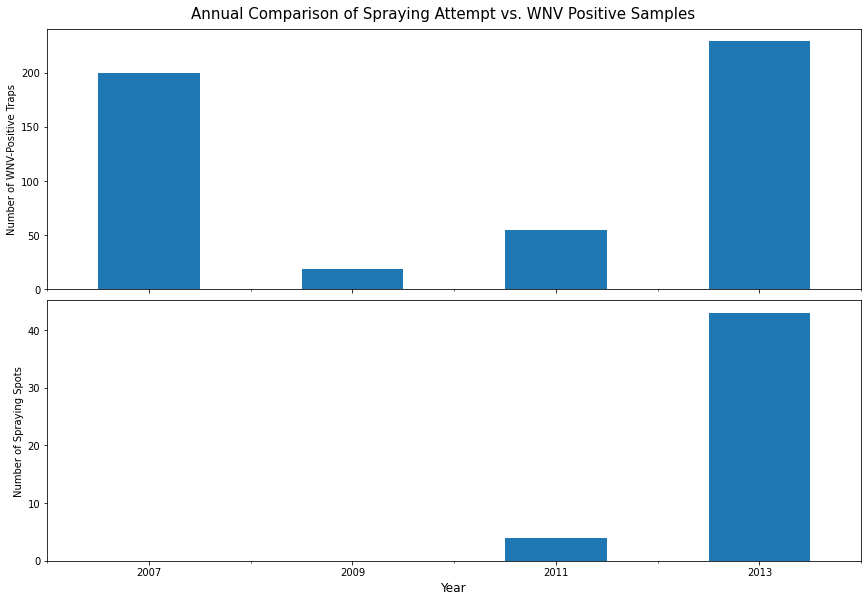

In [9]:
### Effectiveness of Spraying ###
fig, ax = plt.subplots(nrows=2, figsize=(12,8), sharex=True)

# Plot 1 - WNV-Positive Trap
train.set_index('Date').resample('2Y').sum()['WnvPresent'].plot(kind='bar', ax=ax[0])
ax[0].set_ylabel('Number of WNV-Positive Traps')

# Plot 2 - Spraying
train.set_index('Date').resample('2Y').sum()['IsSprayed'].plot(kind='bar', ax=ax[1])
ax[1].set_ylabel('Number of Spraying Spots')

# Global Setting
plt.xticks(range(4), ['2007', '2009', '2011', '2013'], rotation=0)
plt.xlabel('Year', fontsize=12)
plt.tight_layout(pad=0.5)
fig.suptitle('Annual Comparison of Spraying Attempt vs. WNV Positive Samples', x=0.51, y=1.03, fontsize=15)
plt.show()

From the chart above, the annual count of spraying is compared against the WNV positive samples in Chicago. There was no spray data available for 2007 and 2009, without enough information, we cannot confirm that there wasn't any spraying carried out in the 2 years. However, the chart has shown that the number of spraying spots increased proportionately to the number of WNV samples. It was most likely that the spraying increased as a response to the higher WNV samples detected or reported. So the spraying attempt by the authority was comparitively reactive rather than proactive.

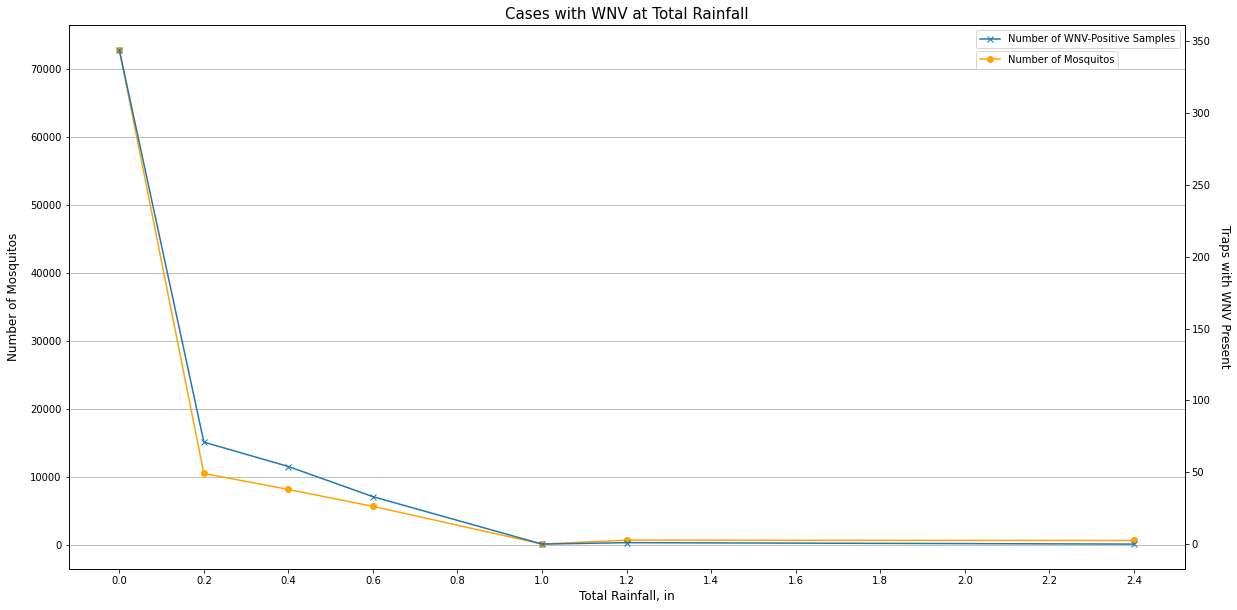

In [10]:
### Effect of Raining on Mosquitos Count ###

def plot_precip(compound):
    fig, ax = plt.subplots(figsize=(20,10))

    # Compound data to specifed scale
    temp = train.groupby('PrecipTotal').sum()
    temp = temp.groupby(temp.index // compound).sum().reset_index()[['PrecipTotal', 'WnvPresent', 'NumMosquitos']]
    temp.PrecipTotal = temp.PrecipTotal * compound

    # Plot 1 - Mosquitos Count
    temp.set_index('PrecipTotal')['NumMosquitos'].plot(ax=ax, color='orange', marker='o', label='Number of Mosquitos')
    ax.set_ylabel('Number of Mosquitos', fontsize=12, labelpad=10)
    ax.legend(loc=(0.813, 0.92))
    ax.grid(axis='y')

    # Plot 2 - WNV-Positive Traps
    ax2 = ax.twinx()
    temp.set_index('PrecipTotal')['WnvPresent'].plot(ax=ax2, marker='x', label='Number of WNV-Positive Samples')
    ax2.set_ylabel('Traps with WNV Present', fontsize=12, labelpad=20, rotation=270)
    ax2.legend(loc=0)

    # Global Setting
    plt.xticks(np.arange(0, 2.6, 0.2))
    ax.set_xlabel('Total Rainfall, in', fontsize=12)
    plt.title('Cases with WNV at Total Rainfall', fontsize=15)
    plt.show()

plot_precip(compound=0.2)

The above line graph shows the precipitation (or rainfall) is inversely proportionatal to both the number of mosquitos and number of WNV-positive traps. The numbers are especially high when there is no rainfall at all; while it still thrives at rain amount that is less than 1 inch. After which, the WNV-positive trap counts fell to zero with mosquitos count hovering around zero as well.

The observation of precipitation is most likely due to the case where heavy downpour washing away the mosquito larvae at higher amounts of precipitation.

## 2.2 Datetime Correlation

Next up, we will look into the datetime correlation between the features and the WNV-positive trap count and the number of mosquitos. This would provide an insight into the seasonality of WNV outbreak in Chicago.

### 2.2.1 Seasonality

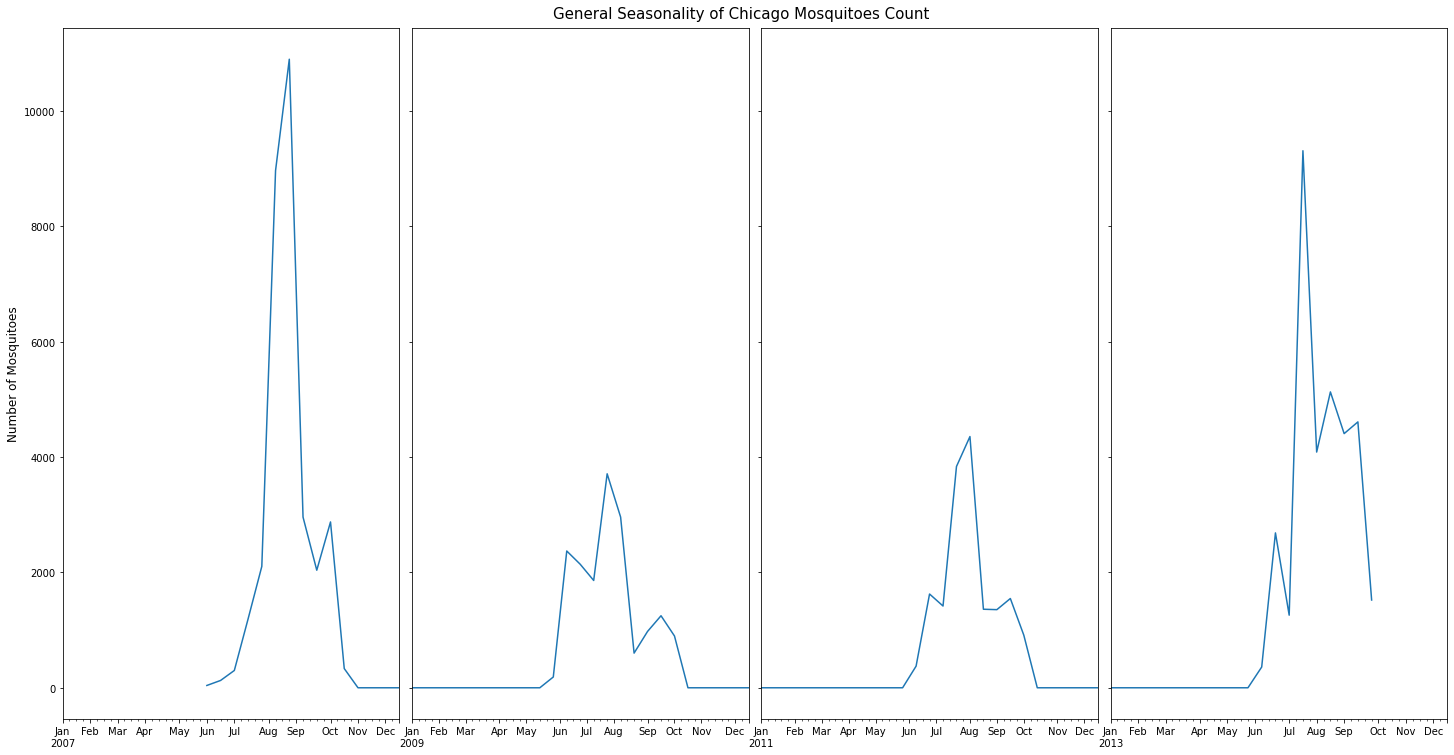

In [11]:
### General Seasonality of Chicago Mosquitoes Count ###
fig, ax = plt.subplots(ncols=4, figsize=(20,10), sharey=True)

# Alternate years in training data
years = ['2007', '2009', '2011', '2013']

for i in range(4):
    # Plotting one subplot for each alternate-year
    train.set_index('Date').resample('2W').sum()['NumMosquitos'].sort_index().plot(ax=ax[i])
    ax[i].set_xlim(years[i]+'-01', years[i]+'-12-15')
    ax[i].set_xlabel('')

# Global Setting
fig.suptitle('General Seasonality of Chicago Mosquitoes Count', x=0.51, y=1.03, fontsize=15)
ax[0].set_ylabel('Number of Mosquitoes', fontsize=12)
plt.tight_layout(pad=0)

plt.show()

The above graph shows that mosquitos start breeding between Jun- Oct periods every year, most likely following the change of seasons. It also shows that the mosquito levels were high in 2007 and 2013 than 2009 and 2011.

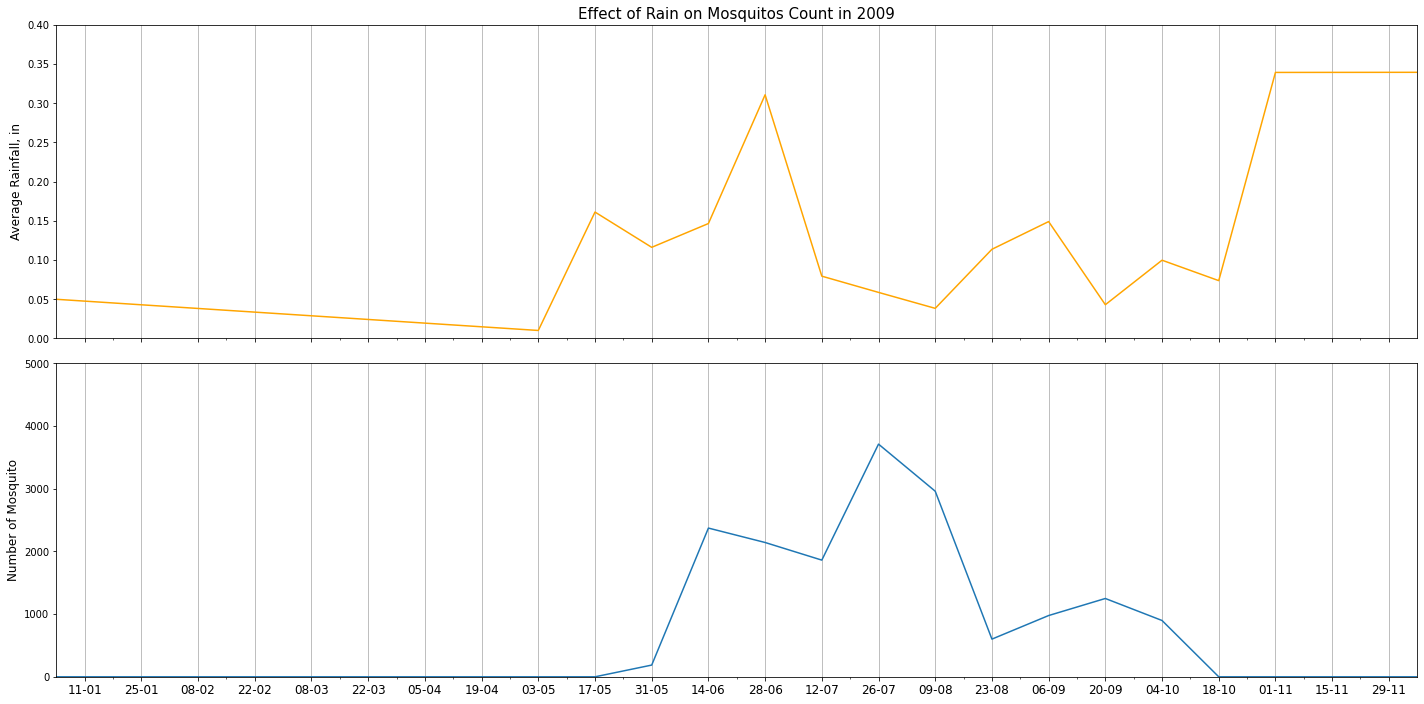

In [12]:
### Raining Seasonality on Mosquitoes Count ###
fig, ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True)

# Plot 1 - Rainfall resampled at 2-week Interval
weather.set_index('Date').resample('2W').mean()['PrecipTotal'].interpolate(method='time').plot(ax=ax[0], 
                                                                                        color='orange', 
                                                                                        label='Average Rainfall, in')
ax[0].set_ylabel('Average Rainfall, in', fontsize=12)
ax[0].set_ylim(0, 0.4)
ax[0].grid(axis='x')

# Plot 2 - Number of Mosquitos
train.set_index('Date').resample('2W').sum()['NumMosquitos'].interpolate(method='time').plot(ax=ax[1],
                                                                                             label='Mosquito Count')
ax[1].set_ylim(0, 5000)
ax[1].grid(axis='x')

# Global Setting
timeframe = pd.date_range('2007-06-01', '2013-10-01', freq='2W')
plt.xticks(ticks=timeframe, labels=[x.strftime('%d-%m') for x in timeframe], fontsize=12)
ax[0].set_title('Effect of Rain on Mosquitos Count in 2009', fontsize=15)
ax[1].set_xlabel('')
ax[1].set_ylabel('Number of Mosquito', fontsize=12)
plt.xlim('2009-01-01', '2009-12-01')

plt.tight_layout(pad=1.5)
plt.show()

The above graph depicts the relationship between the average rainfall and number of mosquitos in 2009, where each vertical grid on the major x-axis represent 2 weeks. It shows that there is a - one month - lag between the increase in rainfall and the increase in mosquitos. Time is required for the mosquitos to breed, the larvae to grow and populate. Heavy rain tends to wash away the larvae, causing the population to drop; however, if the rain started to subside in the coming days, it gave the mosquitos time and the perfect habitat to repopulate.

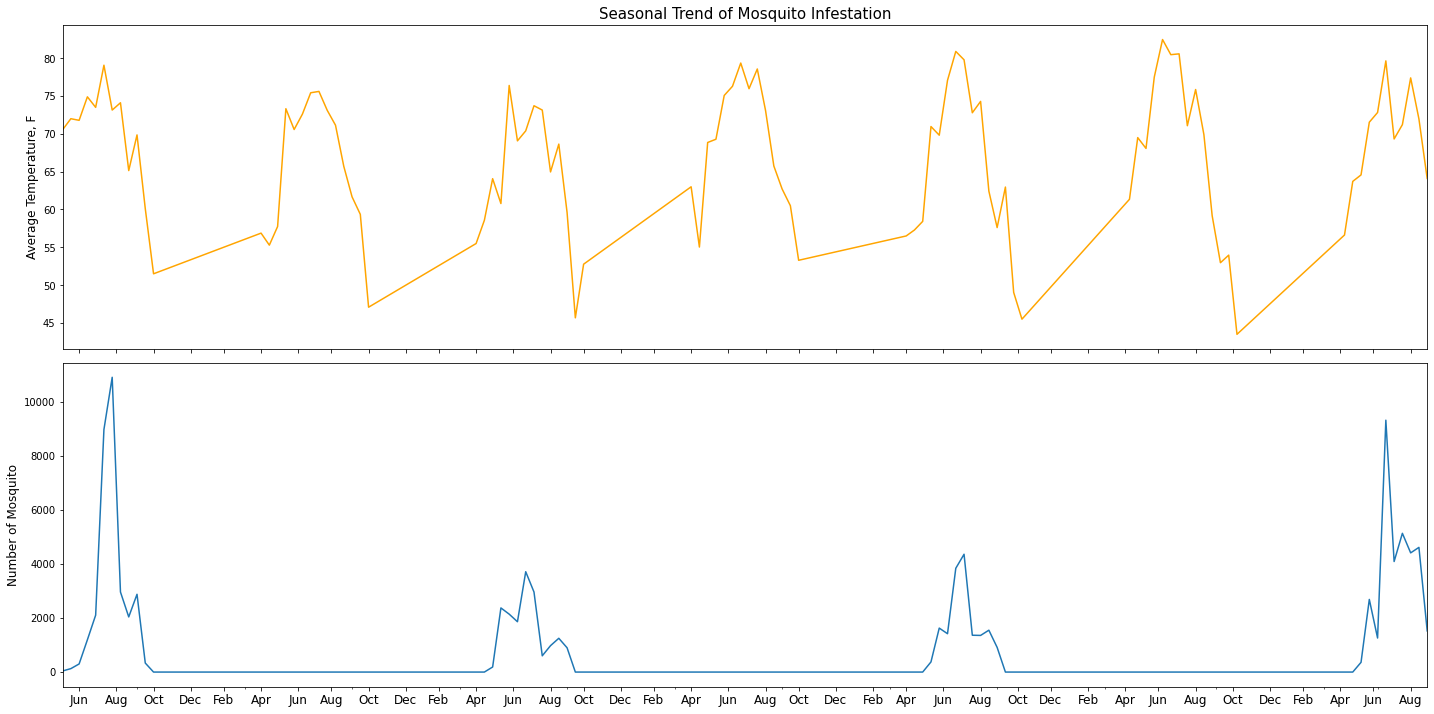

In [13]:
### Temperature Seasonality on Mosquitoes Count ###
fig, ax = plt.subplots(nrows=2, figsize=(20,10), sharex=True)

# Plot 1 - Temperature resampled at 2-week Interval
weather.set_index('Date').resample('2W').mean()['Tavg'].interpolate(method='time').plot(ax=ax[0], 
                                                                                        color='orange', 
                                                                                        label='Temperature')
ax[0].set_ylabel('Average Temperature, F', fontsize=12)
ax[0].tick_params(axis='x', which='minor', bottom=False)

# Plot 2 - Number of Mosquitos
train.set_index('Date').resample('2W').sum()['NumMosquitos'].interpolate(method='time').plot(ax=ax[1],
                                                                                             label='Mosquito Count')
ax[1].set_ylabel('Number of Mosquito', fontsize=12)

# Global Setting
ax[0].set_title('Seasonal Trend of Mosquito Infestation', fontsize=15)
ax[1].set_xlabel('')
timeframe = pd.date_range('2007-06-01', '2013-10-01', freq='2M')
plt.xticks(ticks=timeframe, labels=[x.strftime('%b') for x in timeframe], fontsize=12)

plt.tight_layout(pad=1)
plt.show()

The above graph shows that mosquitos prefer the higher temperatures as when temperature increase so does the number of mosquitoes. However, do note that mosquitos data are missing for the alternate years in the training set, hence producing the interesting gaps every 2 years.

### 2.2.2 Temperature Range

Since the previous graph has shown that there is a very clear seasonality that gives rise to the mosquito count, and in turn to the WNV-positive samples. It would crucial to look into the effect of temperature in detail in the upcoming section.

In [14]:
### Optimal Temperature for Mosquitoes Species ###
def plot_temperature(compound, species=None):
    fig, ax = plt.subplots(figsize=(20,10))

    if species:
        # Plotting one subplot for each species
        for spec in species:

            # Compound data to specifed scale
            temp = train.groupby('Species').get_group(spec).groupby('Tavg').sum()
            temp = temp.groupby(temp.index // compound).sum().reset_index()[['Tavg', 'NumMosquitos']]
            temp.Tavg = temp.Tavg * compound

            # Replace '0' with 'Others'
            if spec == '0':
                temp.rename(columns={'NumMosquitos': 'Others'}, inplace=True)

            else:
                temp.rename(columns={'NumMosquitos': spec}, inplace=True)

            temp.set_index('Tavg').plot(ax=ax)

    else:
        temp = train.groupby('Tavg').sum()
        temp = temp.groupby(temp.index // compound).sum().reset_index()[['Tavg', 'NumMosquitos']]
        temp.Tavg = temp.Tavg * compound
        temp.set_index('Tavg').plot(ax=ax)
        ax.get_legend().remove()

    # Global Setting
    plt.xlabel('Average Temperature, Farenheit', fontsize=12)
    plt.ylabel('Number of Mosquitoes', fontsize=12)
    plt.title('Number of Mosquitoes at Range of Temperature', fontsize=15)
    plt.show()

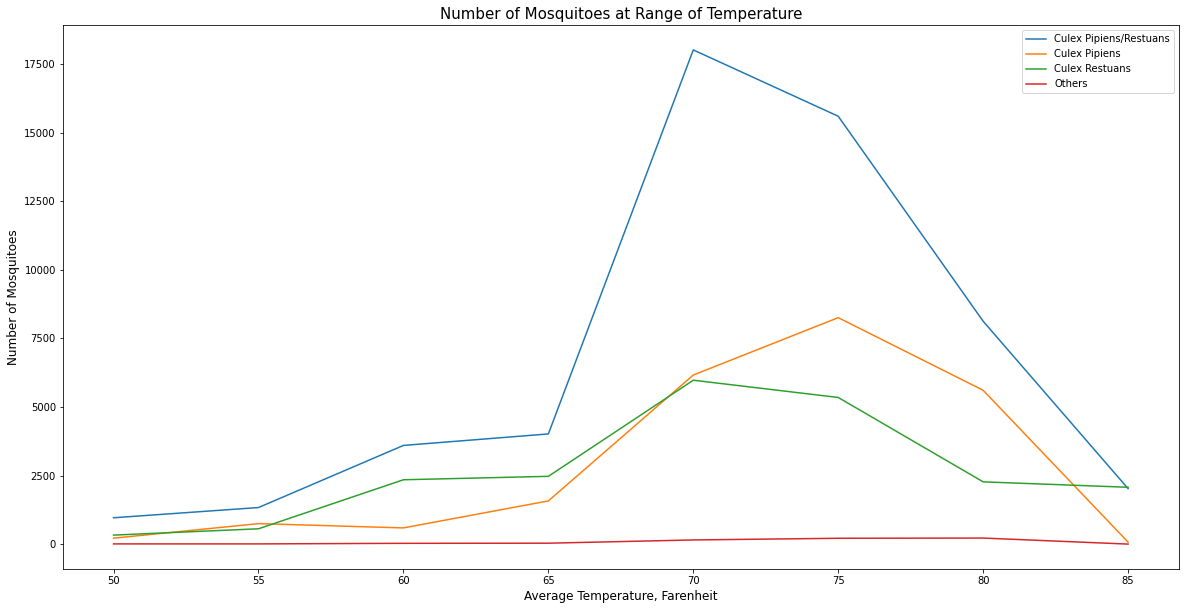

In [15]:
# Plot of optimal temperature range for each species
species = ['Culex Pipiens/Restuans', 'Culex Pipiens', 'Culex Restuans', '0']
plot_temperature(compound=5, species=species)

The above graph shows that the WNV carrying mosquito species prefer a certain temperature range of 65 degrees Fahrenheit and 80 degrees Fahrenheit as the number of mosquitos increase at the start of that range and decrease at the end of the range. There is no significant difference of the optimal temperature between each species.

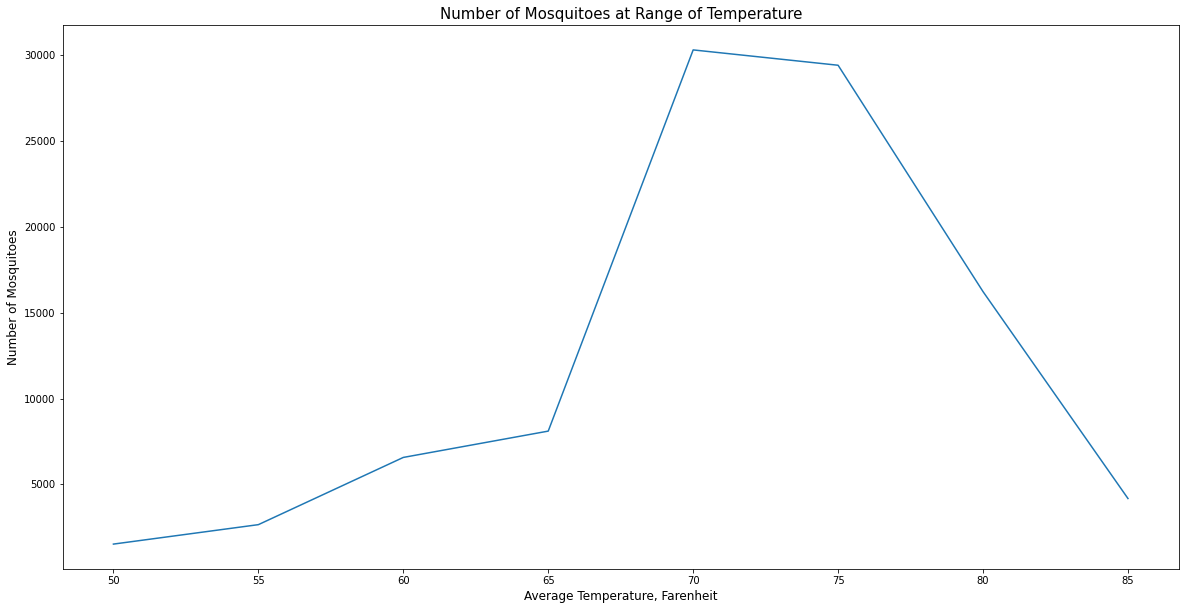

In [16]:
# Plot of optimal temperature range for all mosquitos
plot_temperature(compound=5)

Since there is no difference of optimal temperature range among each mosquito species, it is sufficient to combine them as a whole to observe the effect of temperature on their population. As seen above, the temperature still range between 65 to 80 degree Farenheit, which is a very common temperature during the late spring and entire summer in Chicago.

### 2.2.3 Spraying Effectiveness

As we have seen earlier on the annual comparison of spraying activity to the mosquito population, the spraying attempt was most likely to be reactive from the authority. Now we will zero in to the year of 2011 and 2013 to confirm our speculation and to look out for any abnormality.

In [17]:
### Spraying Timeline vs Number Mosquitos ###
def plot_spray(year):

    # Plot Daily Mosquitos Count Sum
    year = str(year)
    plt.figure(figsize=(20,10))
    train.groupby('Date').sum()['NumMosquitos'].plot(marker='o')

    # Plotting all spraying unique time as vertical red line
    for i, date in enumerate(spray.Date.unique()):
        # If-else-loop to prevent multiple legend plotted
        if i==0:
            plt.axvline(date, color='red', linestyle='dashed', label='Spraying Exercise')
        else:
            plt.axvline(date, color='red', linestyle='dashed')

    # Global Setting
    timeframe = pd.date_range(year+'-06-01', year+'-10-01', freq='W')
    plt.xticks(ticks=timeframe, labels=[x.strftime('%Y-%m-%d') for x in timeframe], rotation=30, fontsize=8)
    plt.xlim(year+'-06-01', year+'-10-01')
    plt.xlabel('')
    plt.ylabel('Number of Mosquitoes')
    plt.title('Chicago Mosquitoes Count in ' + year)
    plt.legend()

    plt.show()

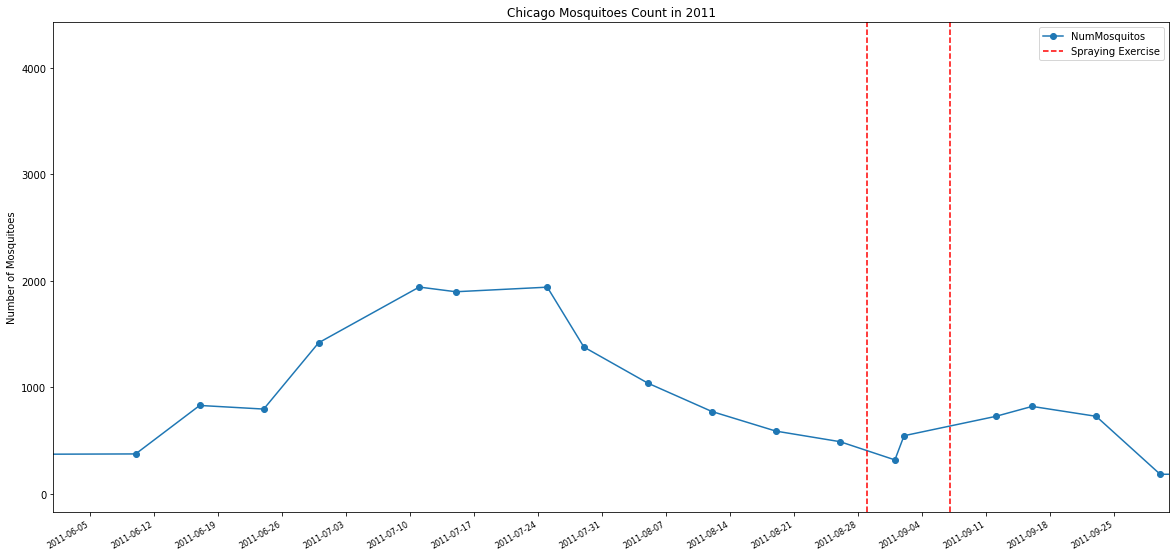

In [18]:
# Spraying plot in 2011
plot_spray(2011)

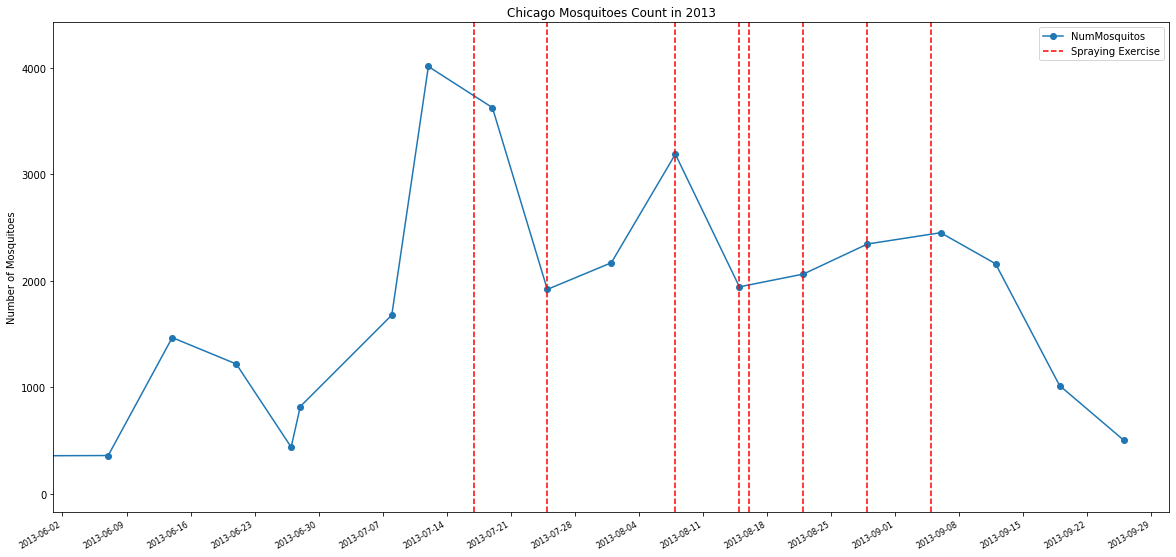

In [19]:
# Spraying plot in 2013
plot_spray(2013)

The above 2 graphs show that spraying in 2011 and 2013 has an effect of decreasing the number of mosquitos as the number of mosquitos decrease after each spraying event. Nevertheless, as expected, the spraying activity was only performed after there was a spike in the number of mosquitos. Thus confirming our theory of spraying being in a reactive nature. But it is very hard to deduce the effectiveness of spraying by observing the chart alone because the temperature and rainfall both have a huge effect on the mosquito count as well.

## 2.3 Geo-Spatial Correlation

Now we will dive into the geo-spatial correlation between the geographics and the number of mosquitos or WNV-positive trap count. By converting the coordinates of each data entry into a discrete neighbourhood, it illustates a better high-level view of geographical significance. Coordinates are not a good indicator for the model as the value of latitude and longitude has limited logical effect mathematically to our target variable.

### 2.3.1 Neighbourhood Ranking

In the section, we will group the entries by their respective neighbourhood to check if there is a certain area in Chicago that are heavily infested by mosquitos and West Nile Virus.

In [20]:
# Create DataFrame with the total of Mosquitos count and WNV-Positive samples per Neighbourhood
neighbourhood = pd.DataFrame(train.groupby('Neighbourhood').sum()[['NumMosquitos', 'WnvPresent']]).reset_index()

In [23]:
neigh_df = pd.read_csv('./assets/neighbourhood.csv')
neighbourhood = pd.merge(neighbourhood, neigh_df, how='left', 
                         left_on='Neighbourhood', right_on='pri_neigh').drop(['pri_neigh', 'shape_area'], axis=1)

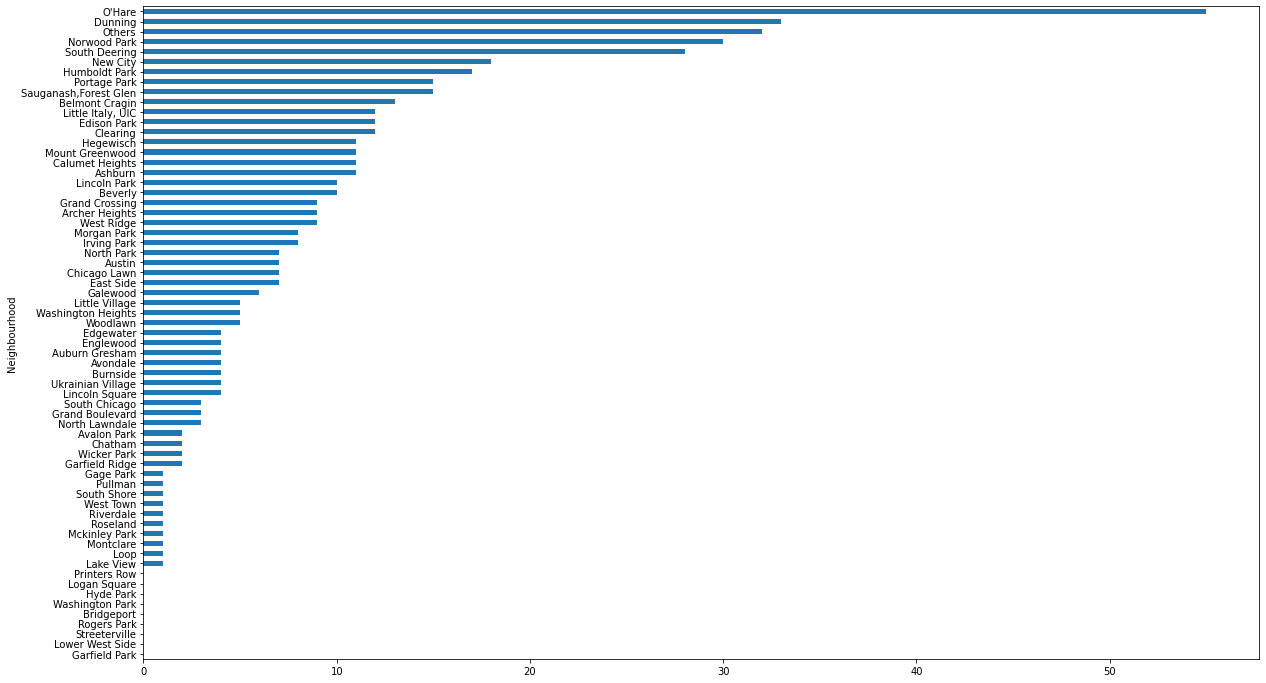

In [24]:
plt.figure(figsize=(20, 12))
neighbourhood.set_index('Neighbourhood')['WnvPresent'].sort_values().plot(kind='barh')
plt.show()

The graph shows the number of WNV samples found in the various neighborhoods of Chicago. O'Hare Airport has the highest number of WNV samples, a high risk area for WNV transmission while areas like Hyde Park and Washington Park have no WNV samples found. Therefore, clearly there are a certain neighbourhood that are better off with the WNV infestation than the others.

The distribution of these areas can be better illustated with the help of map.

In [25]:
def plot_chicago_map(column, thres=0.75, unit='cases'):
    chicago_map = folium.Map(location=[41.835, -87.53], zoom_start=10, 
                         min_zoom=10, max_zoom=14) 

    chicago_map.choropleth(
        geo_data=r'https://data.cityofchicago.org/api/geospatial/bbvz-uum9?method=export&format=GeoJSON',
        data=neighbourhood,
        columns=['Neighbourhood',column],
        key_on='feature.properties.pri_neigh',
        fill_color='RdPu', 
        fill_opacity=0.7, 
        line_opacity=1,
        legend_name=column,
        nan_fill_color='white',
        nan_fill_opacity=0.7
    )

    shortlist = neighbourhood[neighbourhood[column]>neighbourhood[column].quantile(thres)].dropna()

    for name, col, lat, lon in zip(shortlist['Neighbourhood'], shortlist[column], shortlist['lat'], shortlist['lon']):
        popup = name + ' : \n' + str(col) + ' ' + unit
        label = folium.Popup(popup, parse_html=True, max_width=450)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='black',
            weight=1.6,
            fill=True,
            fill_color='white',
            fill_opacity=0.7).add_to(chicago_map)

    return chicago_map

In [26]:
plot_chicago_map('WnvPresent')

The map above shows the distribution of WNV-positive trap count in each neighbourhood. Point marker were plotted at area that are above the 70th percentile. We can see that the situation is extremely bad on the North-West end of the city of Chicago. Down South in the neighbourhood of South Deering, the situation is faily worrying as well.

In [27]:
plot_chicago_map('NumMosquitos', unit='mosquitos')

Now if we look at the distribution of mosquitos population in Chicago, it clearly mirrors the geographical distribution of WNV-positive trap count in the previous map. Same as before, the WNV infestation is rather serious in the North West and South East corners of Chicago. South Deering and the O'Hare Airport are the worst among all neighbourhoods.

South Deering is actually a marshland and 80% of the community is zoned as industrial, natural wetlands, or parks. On the other hand, O'Hare has several retention basin that was supposed to be storm-control facitily for the airport; however, these standing water during dry days provides a perfect environment for the breeding of mosquitos. These explains why the number of mosquitos is at its extreme at these areas.

# 3 Feature Selection

In [28]:
# Dropping columns that have no information contributing to modeling work
train.drop(['Date', 'Neighbourhood', 'NumMosquitos', 'Latitude', 'Longitude'], axis=1, inplace=True)

In [29]:
# Sanity check on the balance columns
train.columns

Index(['Species', 'WnvPresent', 'IsSprayed', 'Tmax', 'Tmin', 'Tavg', 'Depart',
       'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'BR', 'HZ', 'RA', 'TSRA', 'VCTS', 'TS', 'DZ', 'FG',
       'Neighbourhood_Ave_Wnv'],
      dtype='object')

## 3.1 Removal of Collinear Features

In [30]:
# Get the number of classes in each columns
unique_counts = train.apply(pd.Series.value_counts).notna().sum()

# Getting only continuous variable for correlation study
conti_cols = unique_counts[unique_counts>2].index

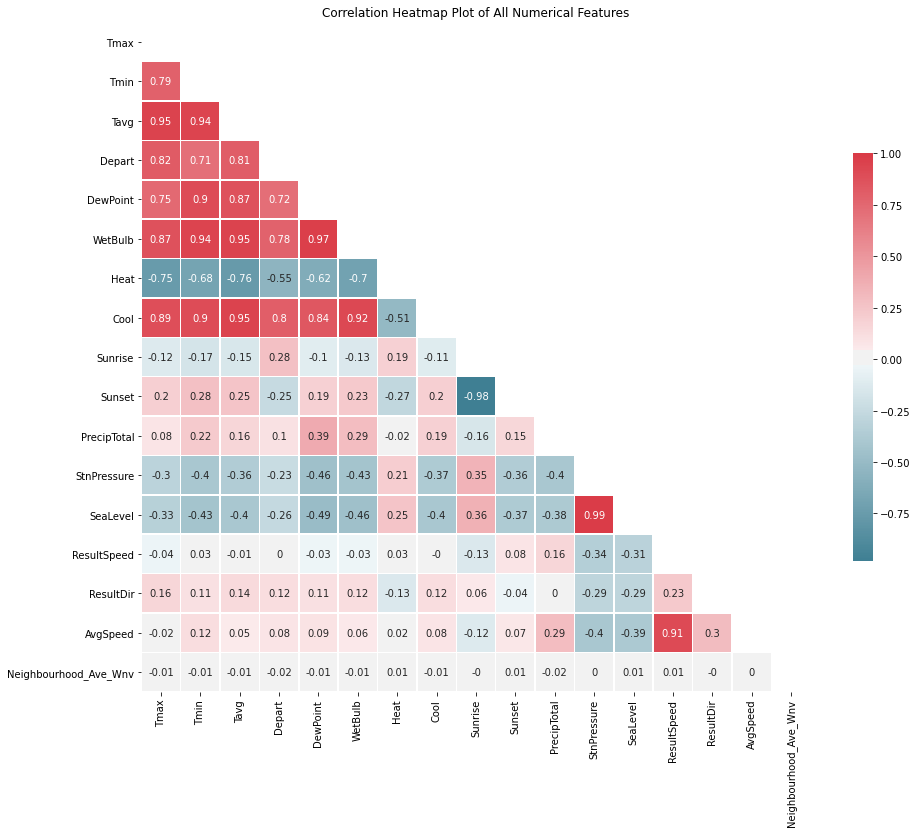

In [31]:
# Plotting correlation heatmap
corr = round(train[conti_cols].corr(),2)
plt.figure(figsize=(15,15))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, square=True, annot=True, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={'shrink':0.5})
plt.title('Correlation Heatmap Plot of All Numerical Features')
plt.show()

As seen in the heatmap, there are several features that are highly correlated. Some of the collinear features should be removed to reduce the dimensionality of our final model. These will cause some variance in the data to lose, but it will also make our model more generalized for future use on unseen data.

In [32]:
# Loop to remove any collinear variable
correlated_features = set()

for i in range(len(corr.columns)):
    for j in range(i):
        if abs(corr.iloc[i, j]) > 0.9:
            colname = corr.columns[i]
            correlated_features.add(colname)

print("Collinear Columns to drop: ", correlated_features)

Collinear Columns to drop:  {'WetBulb', 'Sunset', 'SeaLevel', 'Cool', 'AvgSpeed', 'Tavg'}


In [33]:
train = train.drop(correlated_features, axis=1)

In [34]:
train.columns

Index(['Species', 'WnvPresent', 'IsSprayed', 'Tmax', 'Tmin', 'Depart',
       'DewPoint', 'Heat', 'Sunrise', 'PrecipTotal', 'StnPressure',
       'ResultSpeed', 'ResultDir', 'BR', 'HZ', 'RA', 'TSRA', 'VCTS', 'TS',
       'DZ', 'FG', 'Neighbourhood_Ave_Wnv'],
      dtype='object')

# 4 Feature Engineering

## 4.1 One-Hot Encoding

In [35]:
train = pd.get_dummies(train, drop_first=True)

test = pd.get_dummies(test, drop_first=True)

In [36]:
train.columns

Index(['WnvPresent', 'IsSprayed', 'Tmax', 'Tmin', 'Depart', 'DewPoint', 'Heat',
       'Sunrise', 'PrecipTotal', 'StnPressure', 'ResultSpeed', 'ResultDir',
       'BR', 'HZ', 'RA', 'TSRA', 'VCTS', 'TS', 'DZ', 'FG',
       'Neighbourhood_Ave_Wnv', 'Species_Culex Pipiens',
       'Species_Culex Pipiens/Restuans', 'Species_Culex Restuans'],
      dtype='object')

# 5 Modelling

## 5.1 Preprocessing

### 5.1.1 Train-Test Split

In [37]:
X = train.drop('WnvPresent', axis=1)
y = train['WnvPresent']

In [38]:
round(y.value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                    test_size=0.2, random_state=42)

In [40]:
round(y_train.value_counts(normalize=True), 2)

0    0.95
1    0.05
Name: WnvPresent, dtype: float64

### 5.1.2 Scaling

In [41]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [42]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

## 5.2 Modelling Iteration

Total of 5 different models will be performed in iteration to find out which is the best model in term of generalization and recall. Accuracy is not a good measure for this project because of the heavily-skewed imbalance classes. So all model will be tuned based on the recall score. SMOTE will be carried out in each cross-validation to improve the generalization of each model.

### 5.2.1 Logistic Regression

In [43]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(random_state=42, max_iter=10_000))

print('Validation Score: ', cross_val_score(imba_pipeline, X_train_scaled, y_train, cv=kf, scoring='recall'))

lr_params = {'logisticregression__C': np.linspace(0.1, 1, 20)}

grid_imba = GridSearchCV(imba_pipeline, param_grid=lr_params, cv=kf, scoring='recall')

grid_imba.fit(X_train_scaled, y_train)

print('\n', grid_imba.best_params_, '\n')

best_model_lr = grid_imba.best_estimator_

print('Train Accuracy Score: ', round(best_model_lr.score(X_train_scaled, y_train), 3))
print('Test Accuracy Score: ', round(best_model_lr.score(X_test_scaled, y_test), 3))
print('\nTrain Recall Score: ', round(recall_score(y_train, best_model_lr.predict(X_train_scaled)), 3))
print('Test Recall Score: ', round(recall_score(y_test, best_model_lr.predict(X_test_scaled)), 3))

Validation Score:  [0.7816092  0.82716049 0.7375     0.70833333 0.69512195]

 {'logisticregression__C': 0.6210526315789474} 

Train Accuracy Score:  0.702
Test Accuracy Score:  0.702

Train Recall Score:  0.786
Test Recall Score:  0.772


In [44]:
holdout = test[X.columns].copy()
holdout_scaled = ss.transform(holdout)

In [46]:
test['WnvPresent'] = [prob[1] for prob in best_model_lr.predict_proba(holdout_scaled)]

submission = test[['Id', 'WnvPresent']]

submission.to_csv('./submission/submission_lr.csv', index=False)

 ### 5.2.2 PCA

In [47]:
# Instantiate PCA and LogReg
sm = SMOTE(random_state=42)
pca = PCA()
lr = LogisticRegression(max_iter=10_000, random_state=42)

pipe = Pipeline([('sm', sm), ('pca', pca), ('lr', lr)])

print('Validation Score: ', cross_val_score(pipe, X_train_scaled, y_train, cv=kf, scoring='recall'))

pipe_params = {
    'pca__n_components': [0.1, 0.25, 0.5, 0.75, 1],
    'pca__tol': [0.5, 0.75, 1],
    'lr__C': np.linspace(0.1, 1, 10),
}

grid_pipe = GridSearchCV(pipe, param_grid=pipe_params, cv=kf, scoring='recall')
grid_pipe.fit(X_train_scaled, y_train)

print('\n', grid_pipe.best_params_, '\n')

best_model_lr_pca = grid_pipe.best_estimator_

print('Train Accuracy Score: ', round(best_model_lr_pca.score(X_train_scaled, y_train), 3))
print('Test Accuracy Score: ', round(best_model_lr_pca.score(X_test_scaled, y_test), 3))
print('Train Recall Score: ', round(recall_score(y_train, best_model_lr_pca.predict(X_train_scaled)), 3))
print('Test Recall Score: ', round(recall_score(y_test, best_model_lr_pca.predict(X_test_scaled)), 3))

Validation Score:  [0.7816092  0.82716049 0.7375     0.70833333 0.69512195]

 {'lr__C': 0.1, 'pca__n_components': 0.75, 'pca__tol': 0.5} 

Train Accuracy Score:  0.66
Test Accuracy Score:  0.649
Train Recall Score:  0.704
Test Recall Score:  0.772


We tried Logistic Regression with PCA to improve our scores however our scores were lower than Logistic Regression without PCA.

In [48]:
test['WnvPresent'] = [prob[1] for prob in best_model_lr_pca.predict_proba(holdout_scaled)]

submission = test[['Id', 'WnvPresent']]

submission.to_csv('./submission/submission_pca.csv', index=False)

### 5.2.3 Gaussian Naive Bayes Classifier


In [49]:
pipeline_nb = make_pipeline(SMOTE(random_state=42), 
                              GaussianNB())

print('Validation Score: ', cross_val_score(imba_pipeline, X_train_scaled, y_train, cv=kf, scoring='recall'))

pipe_params_nb = {'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7]}
gs_nb = GridSearchCV(pipeline_nb, 
                  param_grid=pipe_params_nb, 
                  cv=5) 

gs_nb.fit(X_train_scaled, y_train)

print('\n', gs_nb.best_params_, '\n')

best_model_nb = gs_nb.best_estimator_

print('Train Accuracy Score: ', round(best_model_nb.score(X_train_scaled, y_train), 3))
print('Test Accuracy Score: ', round(best_model_nb.score(X_test_scaled, y_test), 3))
print('\nTrain Recall Score: ', round(recall_score(y_train, best_model_nb.predict(X_train_scaled)), 3))
print('Test Recall Score: ', round(recall_score(y_test, best_model_nb.predict(X_test_scaled)), 3))

Validation Score:  [0.7816092  0.82716049 0.7375     0.70833333 0.69512195]

 {'gaussiannb__var_smoothing': 1e-09} 

Train Accuracy Score:  0.613
Test Accuracy Score:  0.609

Train Recall Score:  0.769
Test Recall Score:  0.802


Naive Bayes classifiers are classifiers which use probabilities for their classifications and are based on Bayes' Theorem. They assume that the features are independent from each other and are supposed to achieve high accuracy.

The model's accuracy on both training and testing data are similar, however the recall score for its training data is higher than its testing data which shows overfitting on the training data. Various hyperparameters were tried and the gap decreased but some overfitting still remained.

In [50]:
test['WnvPresent'] = [prob[1] for prob in best_model_nb.predict_proba(holdout_scaled)]

submission = test[['Id', 'WnvPresent']]

submission.to_csv('./submission/submission_gaussiannb_v2.csv', index=False)

### 5.2.4 XGBoost

In [51]:
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              XGBClassifier(random_state=42, objective= 'binary:logistic', verbosity=1, n_jobs=-1))

print('Validation Score: ', cross_val_score(imba_pipeline, X_train_scaled, y_train, cv=kf, scoring='recall'))

xgb_params = {  'xgbclassifier__learning_rate': [0.1],
                'xgbclassifier__max_depth': [3],
                'xgbclassifier__min_child_weight': [5],
                'xgbclassifier__gamma': [0.2],
                'xgbclassifier__subsample': [0.8],
                'xgbclassifier__scale_pos_weight': [1],
                'xgbclassifier__n_estimators': [200]}

grid_imba = GridSearchCV(imba_pipeline, param_grid=xgb_params, cv=kf, scoring='recall')

grid_imba.fit(X_train_scaled, y_train)

print('\n', grid_imba.best_params_, '\n')

best_model_xgb = grid_imba.best_estimator_

print('Train Accuracy Score: ', round(best_model_xgb.score(X_train_scaled, y_train), 3))
print('Test Accuracy Score: ', round(best_model_xgb.score(X_test_scaled, y_test), 3))
print('\nTrain Recall Score: ', round(recall_score(y_train, best_model_xgb.predict(X_train_scaled)), 3))
print('Test Recall Score: ', round(recall_score(y_test, best_model_xgb.predict(X_test_scaled)), 3))

Validation Score:  [0.2183908  0.18518519 0.1875     0.22222222 0.1097561 ]

 {'xgbclassifier__gamma': 0.2, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__scale_pos_weight': 1, 'xgbclassifier__subsample': 0.8} 

Train Accuracy Score:  0.843
Test Accuracy Score:  0.841

Train Recall Score:  0.701
Test Recall Score:  0.653


XGBoost (eXtreme Gradient Boosting)  is an advanced version of gradient boosted decision trees designed to be efficient, flexible and portable.

The model's accuracy score is high on both training and testing data, however the recall score is lower than 0.772 or Logistic Regression. Several hyperparamenters were tried, however as the duration to gridsearch and fit was too long only the above parameters successfuly fit.

In [52]:
test['WnvPresent'] = [prob[1] for prob in best_model_xgb.predict_proba(holdout_scaled)]

submission = test[['Id', 'WnvPresent']]

submission.to_csv('./submission/submission_xgb.csv', index=False)

### 5.2.5 Extra Trees

In [53]:
# imba_pipeline = make_pipeline(SMOTE(random_state=42), 
#                               ExtraTreesClassifier(random_state=42, n_jobs=-1))

# print('Validation Score: ', cross_val_score(imba_pipeline, X_train_scaled, y_train, cv=kf, scoring='recall'))

# et_params = {  'extratreesclassifier__n_estimators': [500],
#                 'extratreesclassifier__min_samples_split': [2],
#                 'extratreesclassifier__min_samples_leaf': [5],
#                 'extratreesclassifier__ccp_alpha': [0]}

# grid_imba = GridSearchCV(imba_pipeline, param_grid=et_params, cv=kf, scoring='recall')

# grid_imba.fit(X_train_scaled, y_train)

# print('\n', grid_imba.best_params_, '\n')

# best_model_et = grid_imba.best_estimator_

# print('Train Accuracy Score: ', round(best_model_et.score(X_train_scaled, y_train), 3))
# print('Test Accuracy Score: ', round(best_model_et.score(X_test_scaled, y_test), 3))
# print('\nTrain Recall Score: ', round(recall_score(y_train, best_model_et.predict(X_train_scaled)), 3))
# print('Test Recall Score: ', round(recall_score(y_test, best_model_et.predict(X_test_scaled)), 3))

<img src=./images/et_params.png>

In [54]:
# instantiate extratrees
et = ExtraTreesClassifier(n_estimators=500,
                          min_samples_split=2,
                          min_samples_leaf=5,
                          ccp_alpha=0,
                          random_state=42,
                          class_weight="balanced")
et.fit(X_train_scaled,y_train)

print('Train Accuracy Score: ', round(et.score(X_train_scaled, y_train), 3))
print('Test Accuracy Score: ', round(et.score(X_test_scaled, y_test), 3))
print('\nTrain Recall Score: ', round(recall_score(y_train, et.predict(X_train_scaled)), 3))
print('Test Recall Score: ', round(recall_score(y_test, et.predict(X_test_scaled)), 3))

Train Accuracy Score:  0.793
Test Accuracy Score:  0.783

Train Recall Score:  0.973
Test Recall Score:  0.743


The Extra Trees classifier or Extremely Randomized Trees Classifier is one of the ensemble learning technique which aggregates the results of multiple de-correlated decision trees collected in a “forest” to output it's classification result. (https://www.geeksforgeeks.org/ml-extra-tree-classifier-for-feature-selection/)

Although the model's train and test accuracy score is higher than Logistic Regression, there is a large difference between the recall score between the train and test data. Several hyperparamenters were tried, however as the duration to gridsearch and fit was too long only the above parameters successfuly fit.



In [58]:
# Submission
test['WnvPresent'] = [prob[1] for prob in et.predict_proba(holdout_scaled)]

submission = test[['Id', 'WnvPresent']]

submission.to_csv('./submission/submission_et.csv', index=False)

# 6 Model Evaluation

| Models | Train Accuracy | Test Accuracy | Train Recall | Test Recall | Holdout Kaggle Score |
| ---- | ---- | ---- | ---- | ---- | ----- |
| Logistic Regression | 0.702 | 0.702 | 0.786 | 0.772 | 0.731 |
| Logistic Regression with PCA | 0.660 | 0.649 | 0.704 | 0.772 | 0.695 |
| Extra Trees | 0.793 | 0.783 | 0.973 | 0.743 | 0.688 |
| Naive-Bayes | 0.613 | 0.609 | 0.769 | 0.802 | 0.606 |
| XGBoost | 0.843 | 0.841 | 0.701 | 0.653 | 0.702 |

We have chosen Logistic Regression without PCA as our production model. The difference between Accuracy and Recall score for train and test data is small which indicates that it would generalise well in unseen data.

In [59]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in best_model_lr.predict_proba(X_test_scaled)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

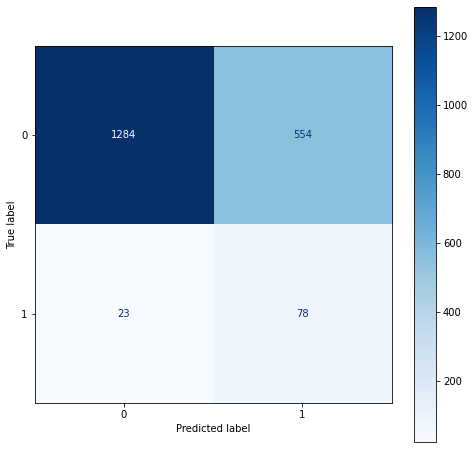

In [60]:
# Confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(best_model_lr, X_test_scaled, y_test, ax=ax, values_format = '.5g',cmap=plt.cm.Blues);

The model has a small number of false negatives which is good as we want to minimize the number of true cases that we miss.

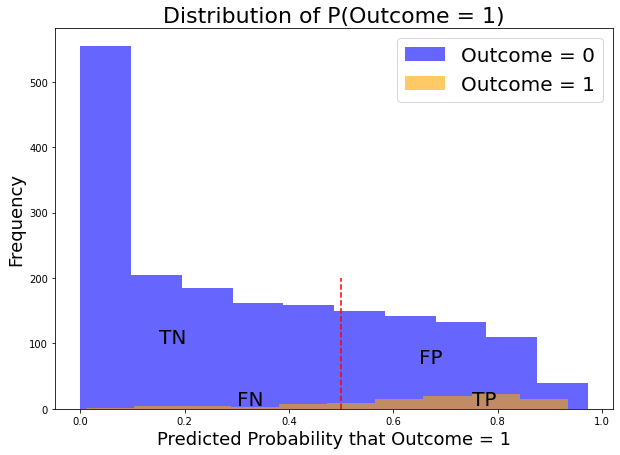

In [61]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'], color = 'b', alpha = 0.6, label = 'Outcome = 0')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'], color = 'orange', alpha = 0.6, label = 'Outcome = 1')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5, ymin = 0, ymax = 200, color = 'r', linestyle = '--')

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.15, 100), s = 'TN', size = 20)
plt.annotate(xy = (0.3, 5), s = 'FN', size = 20)
plt.annotate(xy = (0.75, 5), s = 'TP', size = 20)
plt.annotate(xy = (0.65, 70), s = 'FP', size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

The distribution of the predicted probilities of the negative and positive classes shows that the predicted possibilities of the negative class (blue) is more than the positive class (orange) There is also quite a bit of overlap between both classes.

The threshold shown in the graph is 0.5 which seems an optimal balance to distinguish both the classes. The preference would be for the model to predict more of the positive class than negative class.

In addition, there is a tradeoff between sensitivity and specificity if the threshold is to be moved.

One measure of how much overlap exists between our distributions is the area under the ROC curve.

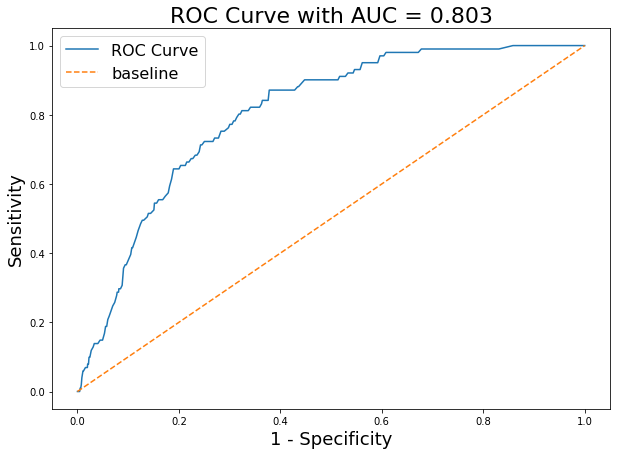

In [62]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, tpr_values, label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200), np.linspace(0, 1, 200), label='baseline', linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [63]:
print("Baseline Score: 0.500")
print("ROC-AUC Score:", round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']), 3))

Baseline Score: 0.500
ROC-AUC Score: 0.803


The AUC - ROC curve or AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve is used to visualize the model's performance is classification. The higher the score , the better the model is predicting the negative and positive class. 

The score of near to 1 or 1 indicates the model has almost perfect or perfect ability to classify between the 2 classes.

The score of 0.5, means model is unable to distinguish either class.

A score of zero means the model is classifying the positive class as the negative class and vice versa.

Our model has a score of 0.8 indicates that it can distinguish between the 2 classes with some accuracy, which should be very good as it is important to predict where the WNV will appear.

In [64]:
spray_eff = np.exp(-pd.Series(best_model_lr.named_steps['logisticregression'].coef_[0], X_train.columns).sort_values()['IsSprayed'])

message = "reduction on WNV Cases"

print("Spraying Effectiveness on WNV:", int(round(spray_eff-1, 2)*100), '%', message)

Spraying Effectiveness on WNV: 7 % reduction on WNV Cases


Lastly, if we look at the coefficient of isSprayed column in the best-performing Logistic Regression model, we could assess the effectiveness of Spraying on reducing WNV cases in Chicago. It has shown that Spraying has only 7% reduction in WNV cases, which is relatively low comparing to the other seasonal climate-related factors. 

However, it is not an absolute indicator of spraying effectiveness on WNV because of the complexity of the circumstances. For example, spraying was not carried out effectively (geographically speaking) by the authority. Furthermore, there were no data of spraying activities on 2007 and 2009 provided, so there is not enough data for the model to capture its true effectiveness.

From the EDA above, it has also shown that the spraying control was carried out on a reactive fashion. Thus, it creates noises to the model in assessing the contribution of spraying. More about the analysis and recommendation are discussed in the 3rd part of the notebook.